In [2]:
import numpy as np
import pandas as pd
import os
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt
from tqdm import tqdm_notebook
%matplotlib inline 
import cv2 as cv

In [4]:
TRAIN_SAMPLE_FOLDER = "C:\\Users\\Wiley\\Desktop\\MASc\Project\\DeepFake_Detection_OpenAI\\Data\\train_sample_videos"
TEST_FOLDER = "C:\\Users\\Wiley\\Desktop\\MASc\\Project\\DeepFake_Detection_OpenAI\\Data\\test_videos"

print(f"Train samples: {len(os.listdir(TRAIN_SAMPLE_FOLDER))}")
print(f"Test samples: {len(os.listdir(TEST_FOLDER))}")

Train samples: 401
Test samples: 400


In [5]:
# Check file types

train_list = list(os.listdir(TRAIN_SAMPLE_FOLDER))
ext_dict_train = []
for file in train_list:
    file_ext = file.split('.')[1]
    if (file_ext not in ext_dict_train):
        ext_dict_train.append(file_ext)
print(f"Train Extensions: {ext_dict_train}")   

for file_ext in ext_dict_train:
    print(f"Train Files with extension `{file_ext}`: {len([file for file in train_list if  file.endswith(file_ext)])}")

test_list = list(os.listdir(TEST_FOLDER))
ext_dict_test = []
for file in test_list:
    file_ext = file.split('.')[1]
    if (file_ext not in ext_dict_test):
        ext_dict_test.append(file_ext)
print(f"\nTest Extensions: {ext_dict_test}")
for file_ext in ext_dict_test:
    print(f"Test Files with extension `{file_ext}`: {len([file for file in train_list if  file.endswith(file_ext)])}")

Train Extensions: ['mp4', 'json']
Train Files with extension `mp4`: 400
Train Files with extension `json`: 1

Test Extensions: ['mp4']
Test Files with extension `mp4`: 400


In [8]:
# Look at metadata file

json_file = [file for file in train_list if  file.endswith('json')][0]
print(f"JSON file: {json_file}")

def get_meta_from_json(path):
    df = pd.read_json(os.path.join(path, json_file))
    df = df.T
    return df

meta_train_df = get_meta_from_json(TRAIN_SAMPLE_FOLDER)
meta_train_df.head()

JSON file: metadata.json


,label,split,original
aagfhgtpmv.mp4,FAKE,train,vudstovrck.mp4
aapnvogymq.mp4,FAKE,train,jdubbvfswz.mp4
abarnvbtwb.mp4,REAL,train,None
abofeumbvv.mp4,FAKE,train,atvmxvwyns.mp4
abqwwspghj.mp4,FAKE,train,qzimuostzz.mp4


In [17]:
# Check number of fakes and real
print('Number of fake videos: ', meta_train_df[meta_train_df.label=='FAKE'].shape[0])
print('Number of fake videos: ', meta_train_df[meta_train_df.label=='REAL'].shape[0])

Number of fake videos:  323
Number of fake videos:  77


In [7]:
# Examining video data and extracting frames from videos (images)

# Check that the metadata aligns with the files in the folder
meta = np.array(list(meta_train_df.index))
storage = np.array([file for file in train_list if  file.endswith('mp4')])
print(f"Metadata: {meta.shape[0]}, Folder: {storage.shape[0]}")
print(f"Files in metadata and not in folder: {np.setdiff1d(meta,storage,assume_unique=False).shape[0]}")
print(f"Files in folder and not in metadata: {np.setdiff1d(storage,meta,assume_unique=False).shape[0]}")

Metadata: 400, Folder: 400
Files in metadata and not in folder: 0
Files in folder and not in metadata: 0


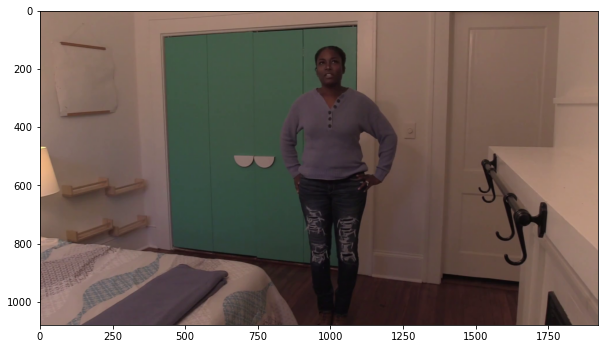

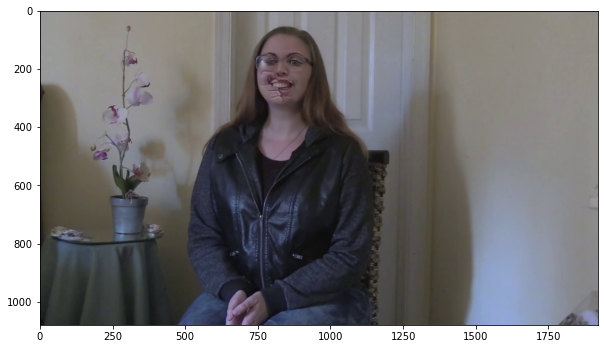

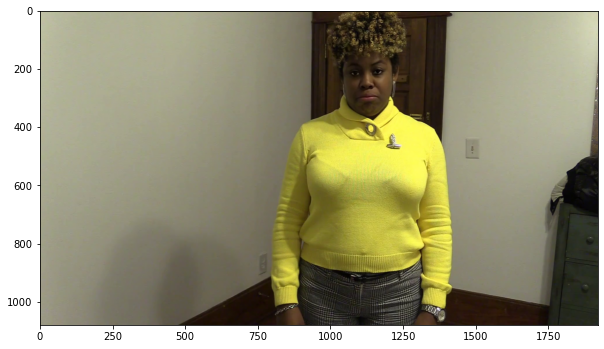

In [11]:
# Display a couple of FAKE videos and images from the video
fake_train_sample_video = list(meta_train_df.loc[meta_train_df.label=='FAKE'].sample(3).index)
fake_train_sample_video

def display_image_from_video(video_path):
    '''
    input: video_path - path for video
    process:
    1. perform a video capture from the video
    2. read the image
    3. display the image
    '''
    capture_image = cv.VideoCapture(video_path) 
    ret, frame = capture_image.read()
    fig = plt.figure(figsize=(10,10))
    ax = fig.add_subplot(111)
    frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
    ax.imshow(frame)

for video_file in fake_train_sample_video:
    display_image_from_video(os.path.join(TRAIN_SAMPLE_FOLDER, video_file))

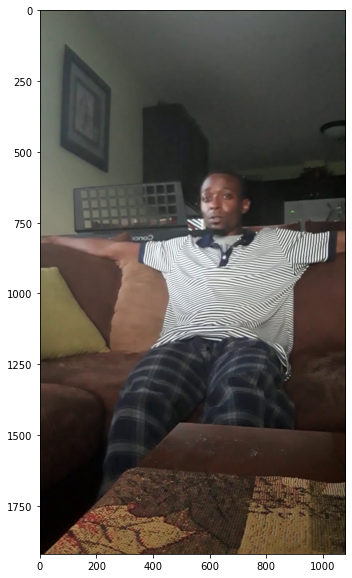

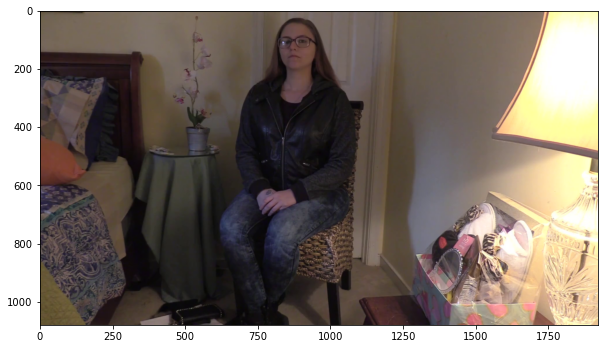

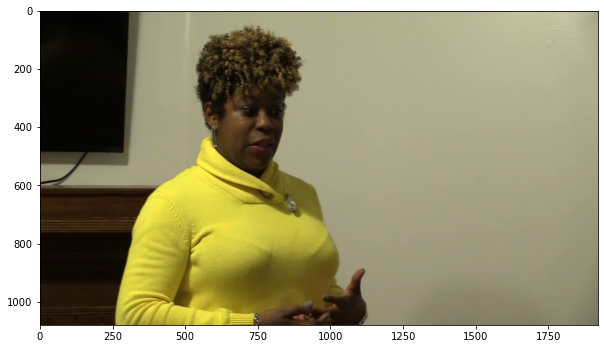

In [10]:
# Display a couple of REAL videos and images from the video
real_train_sample_video = list(meta_train_df.loc[meta_train_df.label=='REAL'].sample(3).index)
real_train_sample_video

for video_file in real_train_sample_video:
    display_image_from_video(os.path.join(TRAIN_SAMPLE_FOLDER, video_file))

<Figure size 432x288 with 0 Axes>

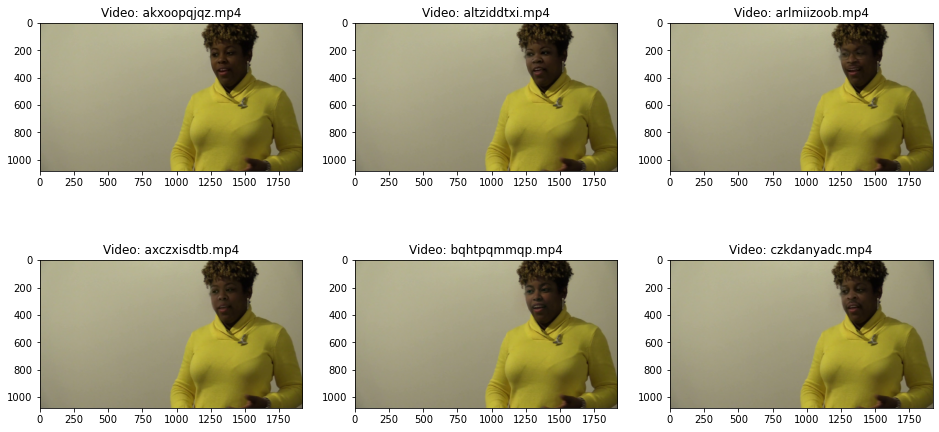

In [15]:
# Looking at the original videos with its corresponding samples (fake)
meta_train_df['original'].value_counts()[0:5]

# Choose original image and modify display function to work w/ multiple images
def display_image_from_video_list(video_path_list, video_folder=TRAIN_SAMPLE_FOLDER):
    '''
    input: video_path_list - path for video
    process:
    0. for each video in the video path list
        1. perform a video capture from the video
        2. read the image
        3. display the image
    '''
    plt.figure()
    fig, ax = plt.subplots(2,3,figsize=(16,8))
    # we only show images extracted from the first 6 videos
    for i, video_file in enumerate(video_path_list[0:6]):
        video_path = os.path.join(video_folder,video_file)
        capture_image = cv.VideoCapture(video_path) 
        ret, frame = capture_image.read()
        frame = cv.cvtColor(frame, cv.COLOR_BGR2RGB)
        ax[i//3, i%3].imshow(frame)
        ax[i//3, i%3].set_title(f"Video: {video_file}")
        ax[i//3, i%3].axis('on')

same_original_fake_train_sample_video = list(meta_train_df.loc[meta_train_df.original=='meawmsgiti.mp4'].index)
display_image_from_video_list(same_original_fake_train_sample_video)

In [43]:
# Looping through frames of a video to create training data list (images)
# Capture a frame every second of the video

frames = []
labels = []
videos = []
count = 0
img_no = 0
frame_rate = 1
directory = os.fsencode(TRAIN_SAMPLE_FOLDER)

for file in os.listdir(TRAIN_SAMPLE_FOLDER):
    video_file = os.fsdecode(file)
    if video_file.endswith('.mp4'):
        videos.append(video_file)

for i in range(len(videos)):
    cap = cv.VideoCapture('C:\\Users\\Wiley\\Desktop\\MASc\\Project\\DeepFake_Detection_OpenAI\\Data\\train_sample_videos\\' + videos[i])
    fps = cap.get(cv.CAP_PROP_FPS) # Equals 29.xx
    frame_rate = 30  # extract 1 frame every 1 second

    if (meta_train_df['label'].iloc[i] == 'FAKE') == True:
        labels.append(1) # 1 = Fake
    else:
        labels.append(0) # 0 = Real
    
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret==True:
            if count%frame_rate == 0:
                frames.append(frame)
                os.chdir('C:\\Users\\Wiley\\Desktop\\MASc\\Project\\DeepFake_Detection_OpenAI\\Data_Images')
                cv.imwrite('Image' + str(img_no) + '_' + str(labels[i]) + '.png', frames[img_no])
                img_no += 1
            count += 1
            if cv.waitKey(1) & 0xFF == ord('q'):
                break
        else:
            break
    cap.release()

In [34]:
# Get FPS

cap = cv.VideoCapture('C:\\Users\\Wiley\\Desktop\\MASc\\Project\\DeepFake_Detection_OpenAI\\Data\\train_sample_videos\\aagfhgtpmv.mp4')
fps = cap.get(cv.CAP_PROP_FPS)
print(fps)

29.97
